In [10]:
# Import libraries
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, Image
import time
%matplotlib inline

In [11]:
def rk4_step(y0, t, f, h, f_args = {}):
    ''' Simple python implementation for one RK4 step. 
        Inputs:
            y_0    - M x 1 numpy array specifying all variables of the ODE at the current time step
            t      - current time step
            f      - function that calculates the derivates of all variables of the ODE
            h      - time step size
            f_args - Dictionary of additional arguments to be passed to the function f
        Output:
            yp1 - M x 1 numpy array of variables at time step t + h
            xp1 - time step t+h
    '''
    k1 = h * f(y0, t, **f_args)
    k2 = h * f(y0 + k1/2., t + h/2., **f_args)
    k3 = h * f(y0 + k2/2., t + h/2., **f_args)
    k4 = h * f(y0 + k3, t + h, **f_args)
    
    xp1 = t + h
    yp1 = y0 + 1./6.*(k1 + 2.*k2 + 2.*k3 + k4)
    
    return(yp1,xp1)

def rk4(y0, t, f, h, n, f_args = {}):
    ''' Simple implementation of RK4
        Inputs:
            y_0    - M x 1 numpy array specifying all variables of the ODE at the current time step
            t      - current time step
            f      - function that calculates the derivates of all variables of the ODE
            h      - time step size
            n      - number of steps
            f_args - Dictionary of additional arguments to be passed to the function f
        Output:
            yn - N+1 x M numpy array with the results of the integration for every time step (includes y0)
            xn - N+1 x 1 numpy array with the time step value (includes start t)
    '''
    yn = np.zeros((n+1, y0.shape[0]))
    xn = np.zeros(n+1)
    yn[0,:] = y0
    xn[0] = t
    E2 = np.zeros((n+1, 2))
    
    for n in np.arange(1,n+1,1):
        yn[n,:], xn[n] = rk4_step(y0 = yn[n-1,:], t = xn[n-1], f = f, h = h, f_args = f_args)
        if len(yn[n,:])==12:
            E2[n, :] = energy(yn[n,:])
     #   print(yn[n,:])
    return(yn, xn, E2)

# Be advised that the integration can take a while for large values of n (e.g >=10^5).


[1.00000000e+00 3.75000000e-01 1.40625000e-01 5.27343750e-02
 1.97753906e-02 7.41577148e-03 2.78091431e-03 1.04284286e-03
 3.91066074e-04 1.46649778e-04 5.49936667e-05]


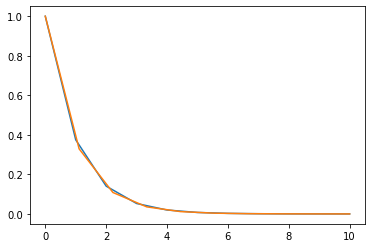

In [12]:
y0 = np.array([1])
t = 0
r = 1

def f(x,t,r):
    return -x

def exp(x):
    return np.exp(-x)

h = 1
n = 10

a,b,e=rk4(y0, t, f, h, n, f_args = {"r":r})

print(a[:,0])

lin = np.linspace(0,max(b),n)
plt.plot(b,a[:,0])
plt.plot(lin,exp(lin))
#plt.yscale("log")
#plt.xscale("log")

In [13]:
def eom(y,t):
    #y = np.array([x1,y1,x2,y2,x3,y3,vx1,vy1,vx2,vy2,vx3,vy3])
    z = np.zeros(12)
    z[:6] = [y[6], y[7], y[8], y[9], y[10], y[11]]
    r21 = ((y[2] - y[0])**2.0 + (y[3] - y[1])**2.0)**0.5
    r31 = ((y[4] - y[0])**2.0 + (y[5] - y[1])**2.0)**0.5
    r32 = ((y[4] - y[2])**2.0 + (y[5] - y[3])**2.0)**0.5

 # Pairwise forces
    Fx21 = G*m2*m1*(y[2] - y[0])/r21**3.0
    Fy21 = G*m2*m1*(y[3] - y[1])/r21**3.0
    Fx31 = G*m3*m1*(y[4] - y[0])/r31**3.0
    Fy31 = G*m3*m1*(y[5] - y[1])/r31**3.0
    Fx32 = G*m3*m2*(y[4] - y[2])/r32**3.0
    Fy32 = G*m3*m2*(y[5] - y[3])/r32**3.0
    # Accelerations
    z[6] = (Fx21 + Fx31)/m1
    z[7] = (Fy21 + Fy31)/m1
    z[8] = (-Fx21 + Fx32)/m2
    z[9] = (-Fy21 + Fy32)/m2
    z[10] = (-Fx31 - Fx32)/m3
    z[11] = (-Fy31 - Fy32)/m3
    
    return z

In [14]:
def energy(z):
    """Calculate the mechanical energies of the three body system.
    Parameters:
        z: array. Vector of length 12 holding the current position and velocity of the three objects in the
           following manner: z = [x1, y2, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3].
    Returns:
        U: float. The potential energies of the system.
        K: float. The kinetic energies of the system.
    """
    
    # Pairwise distance between objects
    r21 = ((z[2] - z[0])**2.0 + (z[3] - z[1])**2.0)**0.5
    r31 = ((z[4] - z[0])**2.0 + (z[5] - z[1])**2.0)**0.5
    r32 = ((z[4] - z[2])**2.0 + (z[5] - z[3])**2.0)**0.5
    
    # Calculate potential energies
    # First object is "free", second object is moved from infinity to a distance r21 from the first object.
    # Third object is affected gravitationally by both objects.
    U1 = 0
    U2 = -G*m1*m2/r21
    U3 = -G*m1*m3/r31 - G*m3*m2/r32
    U = U1 + U2 + U3
    
    # Calculate kinetic energies of the three objects
    K1 = 0.5*m1*(z[6]**2 + z[7]**2)
    K2 = 0.5*m2*(z[8]**2 + z[9]**2)
    K3 = 0.5*m3*(z[10]**2 + z[11]**2)
    K = K1 + K2 + K3
    
    return U, K

(-1.1888406723621812,
 1.1890680055275598,
 -0.39360735207595504,
 0.3939818323346418)

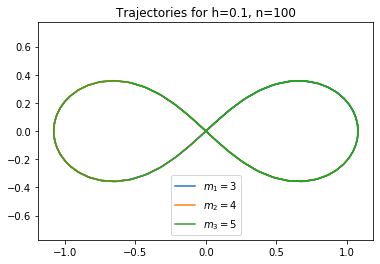

In [19]:
#Initial values
m1 = 1
m2 = 1
m3 = 1
d = 2
G = 1


x1 = -0.97000436
y1 = 0.24308753
x2 = 0.97000436
y2 = -0.24308753
x3 = 0
y3 = 0 
vx1 = -0.46620368
vy1 = -0.43236573
vx2 = -0.46620368
vy2 = -0.43236573
vx3 = 0.93249737
vy3 = 0.86473146

"""
x1 = 1
y1 = 3
x2 = -2
y2 = -1
x3 = 1
y3 = -1 
vx1 = 0
vy1 = 0
vx2 = 0
vy2 = 0
vx3 = 0#-0.1
vy3 = 0
"""

#Array with initial values
y = np.array([x1,y1,x2,y2,x3,y3,vx1,vy1,vx2,vy2,vx3,vy3])

#Initial values for integration
t = 0
h = 0.1
n = 100

#4th order Runge-Kutta-integration
a,b,e = rk4(y, t, eom, h, n, f_args = {})

#Save matrix columns in arrays for plotting
x_1 = a[:,0]
#print(x_1)
y_1 = a[:,1]
#print(y_1)
x_2 = a[:,2]
#print(x_2)
y_2 = a[:,3]
#print(y_2)
x_3 = a[:,4]
#print(x_3)
y_3 = a[:,5]
#print(y_3)

#Plot
plt.plot(x_1,y_1, label="$m_1=3$")
plt.plot(x_2,y_2, label="$m_2=4$")
plt.plot(x_3,y_3, label="$m_3=5$")
plt.legend()
plt.title("Trajectories for h={}, n={}".format(h,n))
plt.axis("equal")
#plt.savefig("a_h_{}.pdf".format(h))

Text(0.5, 1.0, 'Distances over time for h=0.1, n=100')

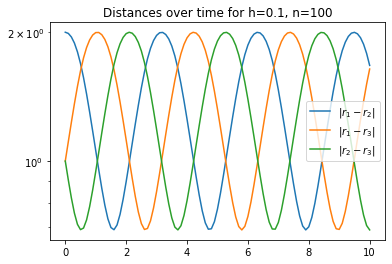

In [20]:
d12 = np.abs(np.sqrt((x_1-x_2)**2+(y_1-y_2)**2))
d13 = np.abs(np.sqrt((x_1-x_3)**2+(y_1-y_3)**2))
d23 = np.abs(np.sqrt((x_2-x_3)**2+(y_2-y_3)**2))
#print(x_1,x_3)

plt.plot(b,d12, label="$|r_1-r_2|$")
#print(d12,d13,d23)
plt.plot(b,d13, label="$|r_1-r_3|$")
plt.plot(b,d23, label="$|r_2-r_3|$")
plt.yscale("log")
plt.legend()
plt.title("Distances over time for h={}, n={}".format(h,n))
#plt.savefig("dist_h_{}.pdf".format(h))

Text(0.5, 1.0, 'Energy for h=0.1, n=100')

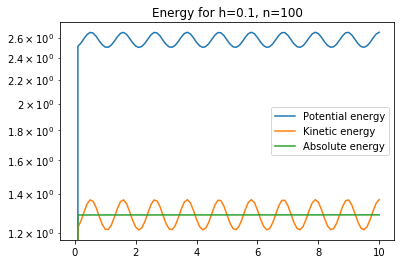

In [21]:
E_pot = e[:,0]
E_kin = e[:,1]
E_ges = E_kin+E_pot


plt.plot(b,np.abs(E_pot),label="Potential energy")
plt.plot(b,E_kin, label="Kinetic energy")
plt.plot(b,np.abs(E_ges),label="Absolute energy")
plt.yscale("log")
plt.legend()
plt.title("Energy for h={}, n={}".format(h,n))
#plt.savefig("energ_h_{}.pdf".format(h))

CalledProcessError: Command '['convert', '-size', '432x288', '-depth', '8', '-delay', '4.0', '-loop', '0', 'rgba:-', 'ThreeBodyProblem5.gif']' returned non-zero exit status 2.

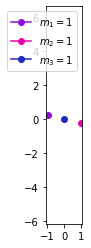

In [9]:
# Set up the figure
fig = plt.figure()
T=5

ax = plt.axes(xlim=(np.min([x_1,x_2,x_3])*1.1, np.max([x_1,x_2,x_3])*1.1), 
              ylim=(np.min([y_1,y_2,y_3])*1.1, np.max([y_1,y_2,y_3])*1.1))
ax.set_aspect('equal')

# Define the different elements in the animation
tail1, = ax.plot([],[],'#910FD7') # Tail obj. 1
tail2, = ax.plot([],[],'#EB05AA') # Tail obj. 2
tail3, = ax.plot([],[],'#1F29C1') # Tail obj. 3
obj1, = ax.plot([],[],'#910FD7', marker="o", label="$m_1={}$".format(m1)) # Obj. 1
obj2, = ax.plot([],[],'#EB05AA', marker="o", label="$m_2={}$".format(m2)) # Obj. 2
obj3, = ax.plot([],[],'#1F29C1', marker="o", label="$m_3={}$".format(m3)) # Obj. 3
plt.legend()
#plt.axis("equal")

# Calculates the number of frames
FPS = 25
framesNum = int(FPS*T)

# Animation function. This is called sequentially.
def animate(j):
    i = j*int(n/framesNum)
    obj1.set_data(x_1[i],y_1[i])
    obj2.set_data(x_2[i],y_2[i])
    obj3.set_data(x_3[i],y_3[i])
    tail1.set_data(x_1[0:i],y_1[0:i])
    tail2.set_data(x_2[0:i],y_2[0:i])
    tail3.set_data(x_3[0:i],y_3[0:i])

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=framesNum)

# Save animation
# If this don't work for you, try using the another writer (ffmpeg, mencoder, imagemagick),
# or another file extension (.mp4, .gif, .ogg, .ogv, .avi etc.). Make sure that you have
# the codec and the writer installed on your system.
anim.save('ThreeBodyProblem5.gif', writer='imagemagick', fps=FPS)

# Close plot
plt.close(anim._fig)

# Display the animation
with open('ThreeBodyProblem5.gif','rb') as file:
    display(Image(file.read()))